In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam, SGD

In [2]:
print("Tensorflow version " + tf.__version__)
np.random.seed(123)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.9.2
Running on TPU  ['10.88.168.2:8470']


In [3]:
# requires training and test data with metadata

rating_df = pd.read_csv('meta_train.csv')
rating_df = rating_df.rename(columns={'User':'u_id','ChannelName':'s_id','z_score_scaled':'rate'})
rating_df.head()

test_df = pd.read_csv('meta_test.csv')
test_df = test_df.rename(columns={'User':'u_id','ChannelName':'s_id','z_score_scaled':'rate'})
test_df.head()

rating_df['Frequency'] = (rating_df['Frequency'] - rating_df['Frequency'].min()) / (rating_df['Frequency'].max() - rating_df['Frequency'].min())    
rating_df['User_Deg'] = (rating_df['User_Deg'] - rating_df['User_Deg'].min()) / (rating_df['User_Deg'].max() - rating_df['User_Deg'].min())    
rating_df['Channel_Deg'] = (rating_df['Channel_Deg'] - rating_df['Channel_Deg'].min()) / (rating_df['Channel_Deg'].max() - rating_df['Channel_Deg'].min())    

test_df['Frequency'] = (test_df['Frequency'] - test_df['Frequency'].min()) / (test_df['Frequency'].max() - test_df['Frequency'].min())    
test_df['User_Deg'] = (test_df['User_Deg'] - test_df['User_Deg'].min()) / (test_df['User_Deg'].max() - test_df['User_Deg'].min())    
test_df['Channel_Deg'] = (test_df['Channel_Deg'] - test_df['Channel_Deg'].min()) / (test_df['Channel_Deg'].max() - test_df['Channel_Deg'].min())  
rating_df.isnull().values.any()
test_df.isnull().values.any()


False

In [4]:
# model requires a random seed
rating_df = rating_df.sample(frac=1, random_state=73)
rating_df.s_id = pd.Categorical(rating_df.s_id)
rating_df['s_id'] = rating_df.s_id.cat.codes
rating_df.dtypes
X = rating_df[['u_id', 's_id','Frequency','User_Deg','Channel_Deg']].values #,
y = rating_df["rate"]

test_df = test_df.sample(frac=1, random_state=73)
test_df.s_id = pd.Categorical(test_df.s_id)
test_df['s_id'] = test_df.s_id.cat.codes
test_df.dtypes
test_in_u = test_df['u_id'].values #,'Frequency','User_Deg','Channel_Deg'
test_in_s = test_df['s_id'].values
test_in_f = test_df['Frequency'].values
test_in_ud = test_df['User_Deg'].values
test_in_cd = test_df['Channel_Deg'].values
test_rating = test_df["rate"]

In [5]:
# traing and validation split lifted from: https://www.kaggle.com/code/chaitanya99/recommendation-system-cf-anime
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_val)))

> Train set ratings: 1419900
> Test set ratings: 10000


In [6]:
X_train_array = [X_train[:, 0], X_train[:, 1],X_train[:, 2],X_train[:, 3],X_train[:, 4]]
X_val_array = [X_val[:, 0], X_val[:, 1],X_val[:, 2],X_val[:, 3],X_val[:, 4]]

In [7]:
#from: https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/NeuMF.py#L158
in_u_dim = len(rating_df["u_id"].unique())
in_s_dim = len(rating_df["s_id"].unique())
 
#changed to 10 
latent_out_dim = 8 #embedding size

# Embedding(input_dim = num_items
# num_users, num_items = train.shape
# output_dim = mf_dim
# mf = 10

In [16]:
# Embedding layers
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers

def ncf(): 
    
    user_gmf = Input(name = 'u_in_gmf', shape = [1])
    stream_gmf = Input(name = 's_in_gmf', shape = [1])
    frequency_gmf = Input(name = 'f_in_gmf', shape = [1])
    user_deg_gmf = Input(name = 'ud_in_gmf', shape = [1])
    channel_deg_gmf = Input(name = 'cd_in_gmf', shape = [1])

    user_embedding_gmf = Embedding(name = 'u_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(user_gmf)
    stream_embedding_gmf = Embedding(name = 's_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_s_dim, output_dim = latent_out_dim)(stream_gmf)
    #meta-----------------------------------------------------------------------------------------------------------------
    frequency_embedding_gmf = Embedding(name = 'f_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(frequency_gmf)
    user_deg_embedding_gmf = Embedding(name = 'ud_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(user_deg_gmf)
    channel_deg_embedding_gmf = Embedding(name = 'cd_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(channel_deg_gmf)
    #----------------------------------------------------------------------------------------------------------------------

    x = tf.keras.layers.Multiply()([user_embedding_gmf, stream_embedding_gmf,frequency_embedding_gmf,user_deg_embedding_gmf,channel_deg_embedding_gmf])
    x = Model(inputs=[user_gmf,stream_gmf,frequency_gmf,user_deg_gmf,channel_deg_gmf], outputs=x)


    user_mlp = Input(name = 'u_in_mlp', shape = [1])
    stream_mlp = Input(name = 's_in_mlp', shape = [1])
    frequency_mlp = Input(name = 'f_in_mlp', shape = [1])
    user_deg_mlp = Input(name = 'ud_in_mlp', shape = [1])
    channel_deg_mlp = Input(name = 'cd_in_mlp', shape = [1])

    user_embedding_mlp = Embedding(name = 'u_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim,output_dim = latent_out_dim)(user_mlp)
    stream_embedding_mlp = Embedding(name = 's_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_s_dim, output_dim = latent_out_dim)(stream_mlp)
    #meta-----------------------------------------------------------------------------------------------------------------
    frequency_embedding_mlp = Embedding(name = 'f_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(frequency_mlp)
    user_deg_embedding_mlp = Embedding(name = 'ud_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(user_deg_mlp)
    channel_deg_embedding_mlp = Embedding(name = 'cd_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(channel_deg_mlp)
    #----------------------------------------------------------------------------------------------------------------------

    y = tf.keras.layers.Concatenate()([user_embedding_mlp, stream_embedding_mlp,frequency_embedding_mlp,user_deg_embedding_mlp,channel_deg_embedding_mlp])
    y = Flatten()(y)

    y = keras.layers.Dense(1, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(2, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(3, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(6, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(7, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(9, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Reshape([1, 10])(y)
    y = Model(inputs=[user_mlp,stream_mlp,frequency_mlp,user_deg_mlp,channel_deg_mlp], outputs=y)


    #combined https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
    #added 2 layers to final ncf
    combined = tf.keras.layers.Concatenate()([x.output, y.output])
    z = Dense(4, activation="relu")(combined)
    z = Dense(2, activation="relu")(combined)
    z = Dense(1, kernel_initializer='lecun_uniform')(combined)
    z = Activation("sigmoid")(z)
  
    model = Model(inputs=[[user_gmf,stream_gmf,frequency_gmf,user_deg_gmf,channel_deg_gmf], [user_mlp,stream_mlp,frequency_mlp,user_deg_mlp,channel_deg_mlp]], outputs=z)

    model.compile(optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
      #https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError
    
    return model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = ncf()
model.summary()
#https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=hJl3vNtJOB-x


#from: https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/NeuMF.py#L65
    # get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    # MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0]/2, name = "mlp_embedding_user",
    #                               init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)
    # MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0]/2, name = 'mlp_embedding_item',
    #                               init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)   
    # for idx in xrange(1, num_layer):
    #     layer = Dense(layers[idx], W_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
    #     mlp_vector = layer(mlp_vector)
    #skipping regularization due to compatibility issues
#https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/NeuMF.py#L15
    # user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    # item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # # Embedding layer
    # MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
    #                               init = init_normal, W_regularizer = l2(reg_mf), input_length=1)
    # MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
    #                               init = init_normal, W_regularizer = l2(reg_mf), input_length=1)   

    # MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0]/2, name = "mlp_embedding_user",
    #                               init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)
    # MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0]/2, name = 'mlp_embedding_item',
    #                               init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)   
    
    # # MF part
    # mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    # mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    # mf_vector = merge([mf_user_latent, mf_item_latent], mode = 'mul') # element-wise multiply

    # # MLP part 
    # mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    # mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    # mlp_vector = merge([mlp_user_latent, mlp_item_latent], mode = 'concat')
    # for idx in xrange(1, num_layer):
    #     layer = Dense(layers[idx], W_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
    #     mlp_vector = layer(mlp_vector)

    # # Concatenate MF and MLP parts
    # #mf_vector = Lambda(lambda x: x * alpha)(mf_vector)
    # #mlp_vector = Lambda(lambda x : x * (1-alpha))(mlp_vector)
    # predict_vector = merge([mf_vector, mlp_vector], mode = 'concat')
    
    # # Final prediction layer
    # prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = "prediction")(predict_vector)
    
    # model = Model(input=[user_input, item_input], output=prediction)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u_in_mlp (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 s_in_mlp (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 f_in_mlp (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 ud_in_mlp (InputLayer)         [(None, 1)]          0           []                               
                                                                                            

In [17]:
# Model training
batch_size = 10000
history = model.fit(
    x=[X_train_array,X_train_array],
    y=[y_train,y_train],
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=([X_val_array, X_val_array], [y_val, y_val])
)

model.save_weights('NCF_with_meta.h5')

Epoch 1/20
142/142 [==============================] - 20s 81ms/step - loss: 0.0955 - root_mean_squared_error: 0.3090 - val_loss: 0.0808 - val_root_mean_squared_error: 0.2843
Epoch 2/20
142/142 [==============================] - 8s 58ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2427
Epoch 3/20
142/142 [==============================] - 8s 59ms/step - loss: 0.0508 - root_mean_squared_error: 0.2255 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2100
Epoch 4/20
142/142 [==============================] - 8s 59ms/step - loss: 0.0386 - root_mean_squared_error: 0.1964 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 5/20
142/142 [==============================] - 8s 59ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1637
Epoch 6/20
142/142 [==============================] - 8s 58ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551 - val_loss: 0.0217

In [18]:
pred_input = [test_in_u, test_in_s, test_in_f, test_in_ud, test_in_cd]
test_pred = model.predict_on_batch([pred_input,pred_input])
test_pred


array([[[0.20654741]],

       [[0.20654741]],

       [[0.20654741]],

       ...,

       [[0.20654741]],

       [[0.20654741]],

       [[0.20654741]]], dtype=float32)

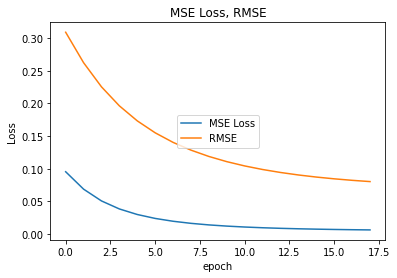

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["root_mean_squared_error"][0:-2])
plt.title("MSE Loss, RMSE")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["MSE Loss", "RMSE"], loc="center")
plt.show()

In [20]:
final_RMSE = (history.history['root_mean_squared_error'])[-1]
final_RMSE

0.07738450914621353

In [21]:
#https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
from sklearn.metrics import mean_squared_error

#rms = mean_squared_error(y_actual, y_predicted, squared=False)
rms = mean_squared_error(test_rating.to_numpy(), test_pred.reshape((len(test_pred),)), squared=False)
rms
#no regulizar 0.2753604126884709
#with regulizer 0.2750856447278888
#with meta normalization 0.27519455599609355
#both larger 0.2756327412193606

0.2756327412193606